# Remember to use GPU runtime (and restart)
Runtime > Change Runtime Type > GPU

# Clone repo and install requirements

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
%cd gdrive/My Drive/Insubria/Magistrale/Tesi/project_folder/NicolaProject/autovc

/content/gdrive/My Drive/Insubria/Magistrale/Tesi/project_folder/NicolaProject/autovc


In [3]:
%%bash
pip install wavenet_vocoder

  Created wheel for wavenet-vocoder: filename=wavenet_vocoder-0.1.1-py3-none-any.whl size=12680 sha256=ac7a6c047d726486b8cc2cac3a7563a4781b90c59ef1a1d6b8783e108ce800f3
  Stored in directory: /root/.cache/pip/wheels/45/b9/b3/5961fda4d2ba5bc9a8d416844b30d590f597674a690162766f
Successfully built wavenet-vocoder


# Import requirements

In [4]:
import os
import pickle
import torch
import numpy as np
from numpy.random import RandomState
from math import ceil
from collections import OrderedDict

from scipy import signal
from scipy.signal import get_window
import librosa
from librosa.filters import mel
import soundfile as sf
from IPython.display import Audio

import matplotlib.pyplot as plt 

from model_bl import D_VECTOR
from model_vc import Generator
from synthesis import build_model
from synthesis import wavegen

# Read Audio

In [5]:
#path1= "wavs/p228/p228_011.wav"
#path2= "wavs/p226/p226_021.wav"

path1= "v1_Pak_70/id0059/English/fLmv5exbzmg/00108.wav"
path2= "v1_Pak_70/id0030/English/OMBLbkLFeGY/00049.wav"

#path2= "italian_audio/i300/galatea_01_barrili_f000006.wav"
#path1= "italian_audio/i301/imalavoglia_00_verga_f000010.wav"

In [6]:
Audio(path1)

In [7]:
Audio(path2)

# Compute spectrogram
Generate spectrogram by a Short Time Futrie Transform (STFT)

In [8]:
def butter_highpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = signal.butter(order, normal_cutoff, btype='high', analog=False)
    return b, a
    
    
def pySTFT(x, fft_length=1024, hop_length=256):
    
    x = np.pad(x, int(fft_length//2), mode='reflect')
    
    noverlap = fft_length - hop_length
    shape = x.shape[:-1]+((x.shape[-1]-noverlap)//hop_length, fft_length)
    strides = x.strides[:-1]+(hop_length*x.strides[-1], x.strides[-1])
    result = np.lib.stride_tricks.as_strided(x, shape=shape,
                                             strides=strides)
    
    fft_window = get_window('hann', fft_length, fftbins=True)
    result = np.fft.rfft(fft_window * result, n=fft_length).T
    
    return np.abs(result)  

In [9]:
mel_basis = mel(16000, 1024, fmin=90, fmax=7600, n_mels=80).T
min_level = np.exp(-100 / 20 * np.log(10))
b, a = butter_highpass(30, 16000, order=5)

In [10]:
def prepare_spectrogram(path, rd_int=None):
    x, fs = sf.read(path)
    y = signal.filtfilt(b, a, x)
    if not rd_int:
      rd_int = int(path.split('/')[-2][1:])
    prng = RandomState(rd_int) # cosa vuol dire?
    wav = y * 0.96 + (prng.rand(y.shape[0])-0.5)*1e-06
    D = pySTFT(wav).T
    D_mel = np.dot(D, mel_basis)
    D_db = 20 * np.log10(np.maximum(min_level, D_mel)) - 16
    S = np.clip((D_db + 100) / 100, 0, 1)  
    S = S.astype(np.float32)
    return S

In [12]:
s1 = prepare_spectrogram(path1, rd_int=255)
print(s1.shape)
s2 = prepare_spectrogram(path2, rd_int=256)
print(s2.shape)

(303, 80)
(281, 80)


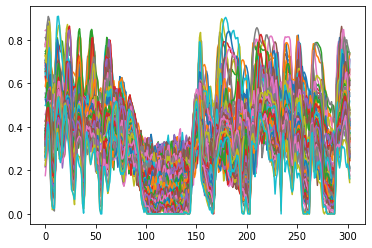

In [13]:
plt.plot(s1)
plt.show()

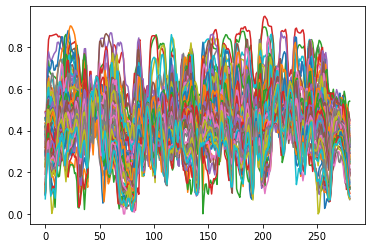

In [14]:
plt.plot(s2)
plt.show()

# Speaker Encoder
Use model_bl to encode the spectrograms

In [15]:
C = D_VECTOR(dim_input=80, dim_cell=768, dim_emb=256).eval().cuda()
c_checkpoint = torch.load('3000000-BL.ckpt')
new_state_dict = OrderedDict()
for key, val in c_checkpoint['model_b'].items():
    new_key = key[7:]
    new_state_dict[new_key] = val
C.load_state_dict(new_state_dict)
num_uttrs = 10
len_crop = 128

In [16]:
def process_speacker(tmp):
    left = np.random.randint(0, tmp.shape[0]-len_crop)
    melsp = torch.from_numpy(tmp[np.newaxis, left:left+len_crop, :]).cuda()
    emb = C(melsp)
    return emb.detach().squeeze().cpu().numpy()

In [17]:
emb1 = process_speacker(s1)
print(emb1.shape)
emb2 = process_speacker(s2)
print(emb2.shape)

(256,)
(256,)


# AutoVC
It use the model_vc to decode both data: input and style

In [18]:
def pad_seq(x, base=32):
    len_out = int(base * ceil(float(x.shape[0])/base))
    len_pad = len_out - x.shape[0]
    assert len_pad >= 0
    return np.pad(x, ((0,len_pad),(0,0)), 'constant'), len_pad

In [19]:
device = 'cuda:0'
G = Generator(32,256,512,32).eval().to(device)

g_checkpoint = torch.load('autovc.ckpt', map_location=device)
G.load_state_dict(g_checkpoint['model'])

<All keys matched successfully>

In [20]:
def prepare_input(s1, emb1, emb2):
    x_org, len_pad = pad_seq(s1)
    uttr_org = torch.from_numpy(x_org[np.newaxis, :, :]).to(device)
    emb_org = torch.from_numpy(emb1[np.newaxis, :]).to(device)
    
    emb_trg = torch.from_numpy(emb2[np.newaxis, :]).to(device)
    
    with torch.no_grad():
            _, x_identic_psnt, _ = G(uttr_org, emb_org, emb_trg)
    if len_pad == 0:
        uttr_trg = x_identic_psnt[0, 0, :, :].cpu().numpy()
    else:
        uttr_trg = x_identic_psnt[0, 0, :-len_pad, :].cpu().numpy()
    return uttr_trg

In [21]:
spect_vc1 = prepare_input(s1, emb1, emb2)
print(spect_vc1.shape)

(303, 80)


# Vocoder
Generate .wav audio file from generated spectrogram

In [22]:
device = torch.device("cuda")
model = build_model().to(device)
checkpoint = torch.load("checkpoint_step001000000_ema.pth")
model.load_state_dict(checkpoint["state_dict"])

<All keys matched successfully>

In [ ]:
name = path1 + '_' + path2
name = name.replace('/', '_')
name = name.replace('.wav', '')
file_output = name + '.wav'
print(file_output)
waveform = wavegen(model, c=spect_vc1)
sf.write('esperimenti/old_vocoder/' + file_output, waveform, 16000, 'PCM_24')

v1_Pak_70_id0059_English_fLmv5exbzmg_00108_v1_Pak_70_id0030_English_OMBLbkLFeGY_00049.wav


 73%|███████▎  | 56979/77568 [08:49<03:08, 109.16it/s]

In [ ]:
Audio('esperimenti/old_vocoder/' + file_output)